In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import contig_reader, utils
from resmico import models_fl as Models
from pathlib import Path
import numpy as np
import seaborn as sns

2022-02-05 12:36:56.973999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
colors = ['#4daf4a', '#e41a1c',  '#377eb8', '#984ea3', '#ff7f00', '#ffff33']
sns.set(font_scale=1.2, style="whitegrid", palette=sns.color_palette(colors))

In [4]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [7]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'
preds_path = project_path + 'Outputs/predictions/'

In [8]:
preds_df = pd.read_csv(preds_path+'kmers-mc40_aucPR_0.727.csv')

In [9]:
n=9
preds_df['cont_name']=preds_df['cont_name'].map(lambda x: '/'.join(x.split('/')[-n:]))

In [10]:
split_name = preds_df['cont_name'].str.split('/', expand = True)
cols = ['kmer', 'f', 'richness', 'abund_dist', 'sim_rep', 'read_length', 'seq_depth', 'assembler', 'cont']
for i, col in enumerate(cols):
    preds_df[col] = split_name[i]

In [22]:
all_kmers = np.sort(preds_df['kmer'].unique())

In [24]:
preds_df

,cont_name,length,label,score,min,mean,std,max,kmer,f,richness,abund_dist,sim_rep,read_length,seq_depth,assembler,cont
0,kmer51-71-91/features/0.005555/mean-10-sigma-1...,1149,0,0.002290,0.002290,0.002290,0.0,0.002290,kmer51-71-91,features,0.005555,mean-10-sigma-1,1,150,2000000,megahit,k91_50819
1,kmer51-71-91/features/0.005555/mean-10-sigma-1...,1109,0,0.003952,0.003952,0.003952,0.0,0.003952,kmer51-71-91,features,0.005555,mean-10-sigma-1,1,150,2000000,megahit,k91_129420
2,kmer51-71-91/features/0.005555/mean-10-sigma-1...,1026,0,0.004528,0.004528,0.004528,0.0,0.004528,kmer51-71-91,features,0.005555,mean-10-sigma-1,1,150,2000000,megahit,k91_9
3,kmer51-71-91/features/0.005555/mean-10-sigma-1...,1112,0,0.001267,0.001267,0.001267,0.0,0.001267,kmer51-71-91,features,0.005555,mean-10-sigma-1,1,150,2000000,megahit,k91_69321
4,kmer51-71-91/features/0.005555/mean-10-sigma-1...,1103,0,0.000728,0.000728,0.000728,0.0,0.000728,kmer51-71-91,features,0.005555,mean-10-sigma-1,1,150,2000000,megahit,k91_108903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034214,kmer21-41-61/features/0.333333/mean-10-sigma-1...,2119,0,0.371659,0.371659,0.371659,0.0,0.371659,kmer21-41-61,features,0.333333,mean-10-sigma-1,1,150,8000000,metaspades,NODE_9222_length_2119_cov_1.597668
1034215,kmer21-41-61/features/0.333333/mean-10-sigma-1...,2118,0,0.326806,0.326806,0.326806,0.0,0.326806,kmer21-41-61,features,0.333333,mean-10-sigma-1,1,150,8000000,metaspades,NODE_9223_length_2118_cov_3.111327
1034216,kmer21-41-61/features/0.333333/mean-10-sigma-1...,2118,0,0.002207,0.002207,0.002207,0.0,0.002207,kmer21-41-61,features,0.333333,mean-10-sigma-1,1,150,8000000,metaspades,NODE_9224_length_2118_cov_2.782693
1034217,kmer21-41-61/features/0.333333/mean-10-sigma-1...,2118,0,0.003108,0.003108,0.003108,0.0,0.003108,kmer21-41-61,features,0.333333,mean-10-sigma-1,1,150,8000000,metaspades,NODE_9225_length_2118_cov_2.654837


In [25]:
#kmer and tech split
error_rate = {'kmer':[], 'tech':[], 
              'true':[], 'pred':[]}
for kmer in all_kmers:
    for tech in ['megahit', 'metaspades']:
        error_rate['kmer'].append(kmer)
        error_rate['tech'].append(tech)
        sel_df = preds_df[(preds_df['kmer']==kmer) & (preds_df['assembler']==tech)]
        error_rate['true'].append(sel_df.label.mean())
        error_rate['pred'].append((sel_df.score>0.5).mean())

In [26]:
def calculate_N50(list_of_lengths):
    numlist = np.array(list_of_lengths)
    numlist.sort()
    newlist = []
    for x in numlist :
        newlist += [x]*x
    # take the mean of the two middle elements if there are an even number
    # of elements. otherwise, take the middle element
    if len(newlist) % 2 == 0:
        medianpos = int(len(newlist)/2)

        return float(newlist[medianpos-1] + newlist[medianpos]) /2
    else:
        medianpos = int(np.ceil(len(newlist)/2))

        return newlist[medianpos-1]

In [27]:
#kmer,tech,rch,sd split
error_rate = {'kmer':[], 'tech':[], 'richness':[], 'seq_depth':[], 'size':[], 'N50':[],
              'true':[], 'pred':[]}
for kmer in all_kmers:
    for tech in ['megahit', 'metaspades']:
        for sd in ['2000000', '8000000']:
            for rch in ['0.005555', '0.333333']:
                ind = (preds_df['kmer']==kmer) & (preds_df['assembler']==tech) \
                        & (preds_df['richness']==rch) & (preds_df['seq_depth']==sd)
                sel_df = preds_df[ind]
                error_rate['kmer'].append(kmer)
                error_rate['tech'].append(tech)
                error_rate['true'].append(sel_df.label.mean())
                error_rate['pred'].append(sel_df.score.mean())
                error_rate['richness'].append(rch)
                error_rate['seq_depth'].append(sd)
                error_rate['size'].append(sum(ind))
                error_rate['N50'].append(calculate_N50(sel_df.length))

In [28]:
error_rate = pd.DataFrame.from_dict(error_rate)

In [29]:
error_rate = error_rate.rename(columns={"kmer": "k-mer set", "tech": "assembler", 
                   'true': 'true error rate', 'pred':'ResMiCo'})

In [30]:
error_rate = error_rate.replace({'0.005555': '50', '0.333333': '3000'})

In [31]:
pearson_n50 = []
pearson_resmico = []
for sd in ['2000000', '8000000']:
    for rch in ['50', '3000']:
        ind = (error_rate['richness']==rch) & (error_rate['seq_depth']==sd)
        corr, _ = pearsonr(error_rate[ind]["true error rate"], error_rate[ind]['ResMiCo'])
        pearson_resmico.append(corr)
        corr, _ = pearsonr(error_rate[ind]["true error rate"], error_rate[ind]['N50'])
        pearson_n50.append(corr)

/cluster/home/omineeva/software/anaconda/envs/resmico/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/kmers_resmico.pdf


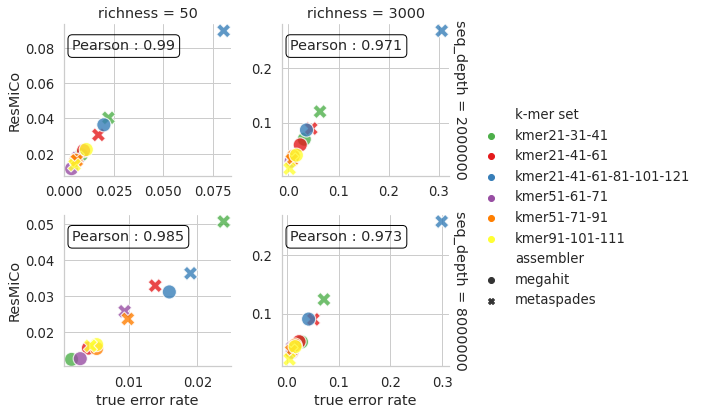

In [32]:
# plt.figure(figsize=(10, 10))

g = sns.FacetGrid(error_rate, col="richness", row='seq_depth',
                  sharex=False, sharey=False,
                  size=3, aspect=1.2,
                  margin_titles=True)
g.map_dataframe(sns.scatterplot, x="true error rate", y="ResMiCo", hue='k-mer set', style='assembler', 
                s=200, alpha=0.8)

props = dict(boxstyle='round', facecolor='none', edgecolor='black')
for i, ax in enumerate(g.axes.ravel()):
    ax.text(.05, .9, 
            'Pearson : ' + str(round(pearson_resmico[i],3)), 
            transform=ax.transAxes, ha="left", va="top", bbox=props)
    
g.add_legend()

dataset_name = 'resmico'
where = project_path+'Outputs/figures/kmers_'+dataset_name+'.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

/cluster/home/omineeva/software/anaconda/envs/resmico/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/kmers_n50.pdf


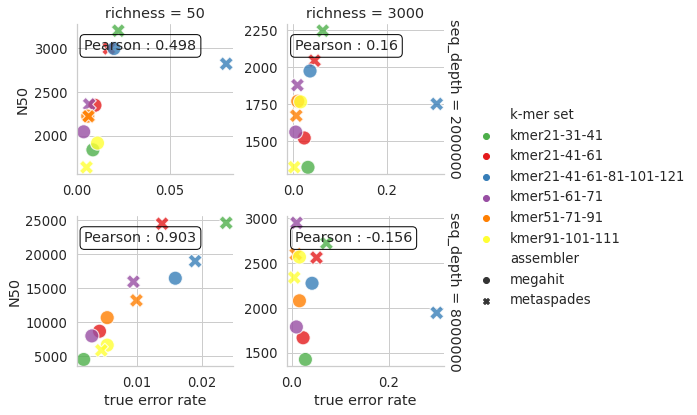

In [33]:
g = sns.FacetGrid(error_rate, col="richness", row='seq_depth',
                  sharex=False, sharey=False,
                  size=3, aspect=1.2,
                  margin_titles=True)
g.map_dataframe(sns.scatterplot, x="true error rate", y="N50", hue='k-mer set', style='assembler', 
                s=200, alpha=0.8)

props = dict(boxstyle='round', facecolor='none', edgecolor='black')
for i, ax in enumerate(g.axes.ravel()):
    ax.text(.05, .9, 
            'Pearson : ' + str(round(pearson_n50[i],3)), 
            transform=ax.transAxes, ha="left", va="top", bbox=props)
    
g.add_legend()

dataset_name = 'n50'
where = project_path+'Outputs/figures/kmers_'+dataset_name+'.pdf'
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)